# Notebook to Generate Benchmark Plots

In [9]:
import matplotlib.pyplot as plt
import json
import glob
import numpy as np

plt.style.use("ggplot")

In [22]:
def extract_benchmarks(json_data):
    """
    Aggregates a list of benchmarks into a dictionary
    that maps benchmark_name --> results for different param values.
    """
    benchmarks = dict()
    for benchmark in json_data["benchmarks"]:
        name = benchmark["name"].split("[")[0]
        param_name = list(benchmark["params"].keys())[0]
        param_val = list(benchmark["params"].values())[0]
        if not name in benchmarks:
            benchmarks[name] = {key: [] for key in benchmark["stats"].keys()}
            benchmarks[name]["param_name"] = param_name
            benchmarks[name]["param_val"] = []
        for key_name, key_value in benchmark["stats"].items():
            benchmarks[name][key_name].append(key_value)
        benchmarks[name]["param_val"].append(param_val)
    return benchmarks

def load_benchmark_data_from_json(filename):
    with open(filename, "r") as fp:
        json_data = json.load(fp)
    return extract_benchmarks(json_data)

def plot_series(benchmark_data, color="C0", label=""):
    params = np.array(benchmark_data["param_val"])
    mean_times = np.array(benchmark_data["mean"])
    isnan = np.isnan(mean_times)
    if np.sum(~isnan) > 1:
        m, b = np.polyfit(params[~isnan], mean_times[~isnan], deg=1)
        plt.plot(params, m * params + b, '--', color=color, label=label)
    else:
        m = 0
        b = mean_times[~isnan]
        plt.plot([], [], '--', color=color, label=label)
    ys = np.copy(mean_times)
    ys[isnan] = m * params[isnan] + b  # replace nans with linear prediction
    for x, y, isna in zip(params, ys, isnan):
        plt.scatter(x, y, marker="x" if isna else "o", 
                    s=80 if isna else 40, 
                    color=color)

def plot_benchmarks(prefix="", jax_prefix="", prev_jax_prefix="", old_prefix="", include_prev=False):
    """
    By default, will use the latest benchmark file.
    args:
        - prefix: match string of .json report (will take latest from matched files)
        - jax_prefix: use if jax file differs from ssm_v0 file
        - old_prefix: use if ssm_v0 file differs from jax file
    """

    if jax_prefix == "":
        jax_prefix = prefix
    if prev_jax_prefix == "":
        prev_jax_prefix = prefix
    if old_prefix == "":
        old_prefix = prefix

    # get last alphabetically sorted fname [generally, most recent] (with optional prefix) 
    ssm_jax_fname = sorted(glob.glob(f".benchmarks/Linux-CPython-3.9-64bit/*{jax_prefix}*.json"))[-1]
    print(ssm_jax_fname)

    if include_prev:
        ssm_jax_prev_fname = sorted(glob.glob(f".benchmarks/Linux-CPython-3.9-64bit/*{prev_jax_prefix}*.json"))[-2]
        print(ssm_jax_prev_fname)

    ssm_old_fname = sorted(glob.glob(f"ssm_v0_benchmark_tests/.benchmarks/Linux-CPython-3.9-64bit/*{old_prefix}*.json"))[-1]
    print(ssm_old_fname)


    # load-in and pre-process some benchmark data
    jax_benchmarks = load_benchmark_data_from_json(ssm_jax_fname)
    if include_prev:
        prev_jax_benchmarks = load_benchmark_data_from_json(ssm_jax_prev_fname)
    old_benchmarks = load_benchmark_data_from_json(ssm_old_fname)

    # plot the different benchmarks
    for benchmark_name in jax_benchmarks:
        plt.figure(figsize=(8, 6))
        if benchmark_name in jax_benchmarks:
            plot_series(jax_benchmarks[benchmark_name], color="blue", label="SSM-JAX")
        if benchmark_name in old_benchmarks:
            plot_series(old_benchmarks[benchmark_name], color="red", label="SSM-v0")
        if include_prev and benchmark_name in prev_jax_benchmarks:
            plot_series(prev_jax_benchmarks[benchmark_name], color="purple", label="SSM-JAX (prev)")
        plt.scatter([], [], marker="x", color="black", label="Errored")
        plt.title(benchmark_name)
        plt.xlabel(jax_benchmarks[benchmark_name]["param_name"])
        plt.ylabel("time (s)")
        plt.legend()
        plt.show()        

.benchmarks/Linux-CPython-3.9-64bit/0002_a8209a16cd8bed2af0f268430f5b3c0523c0a097_20211026_194515.json
.benchmarks/Linux-CPython-3.9-64bit/0001_b1e3bd354ba2d60c22df414fdc5a818ea4a43276_20211026_075238.json
ssm_v0_benchmark_tests/.benchmarks/Linux-CPython-3.9-64bit/0001_a8209a16cd8bed2af0f268430f5b3c0523c0a097_20211026_203852.json


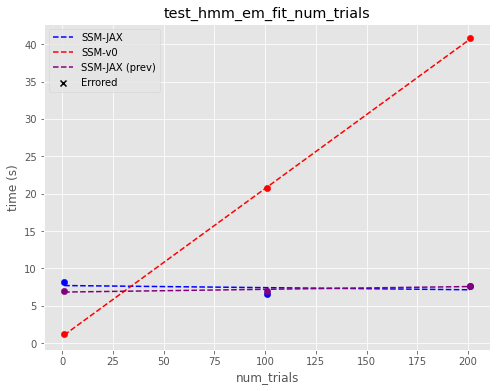

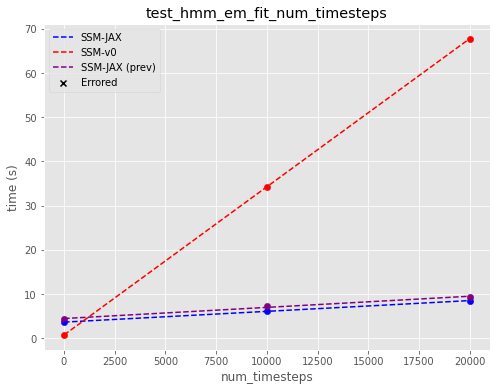

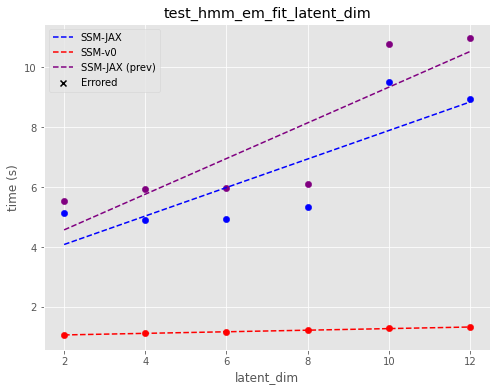

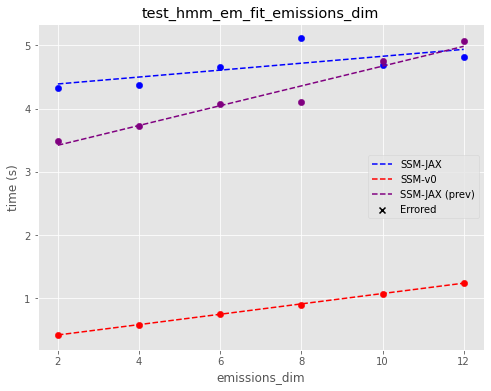

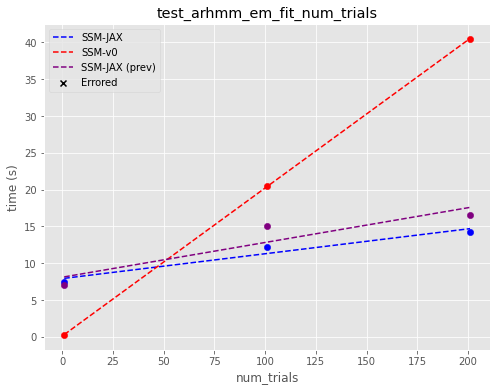

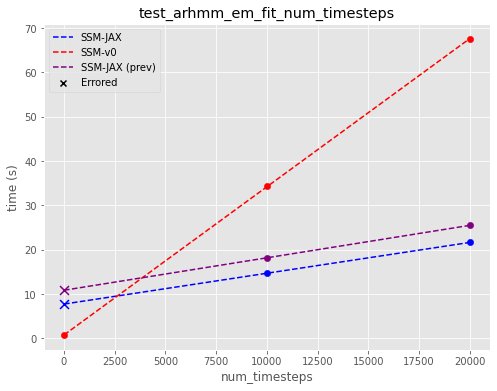

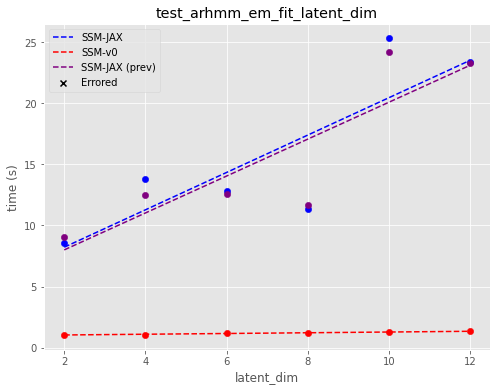

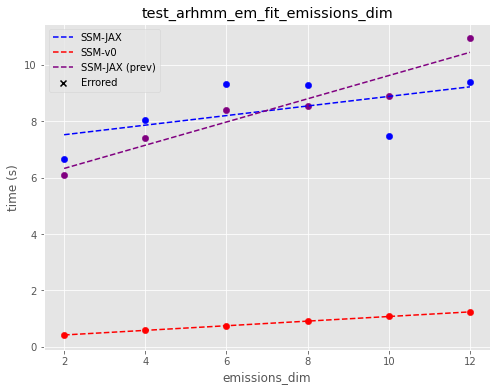

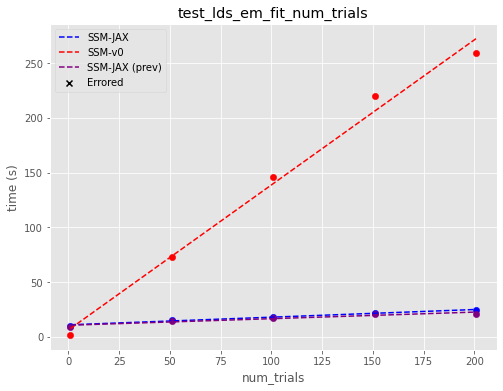

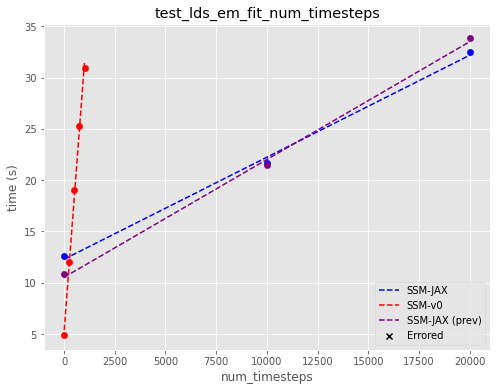

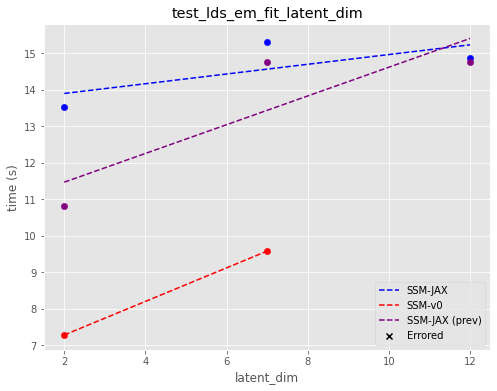

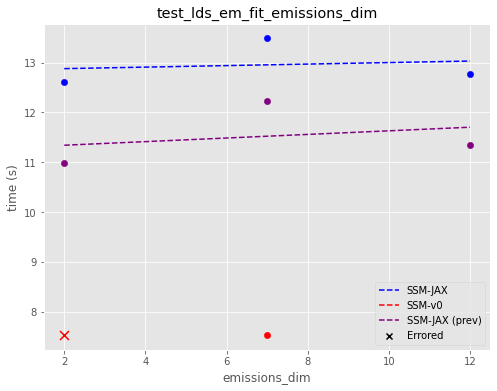

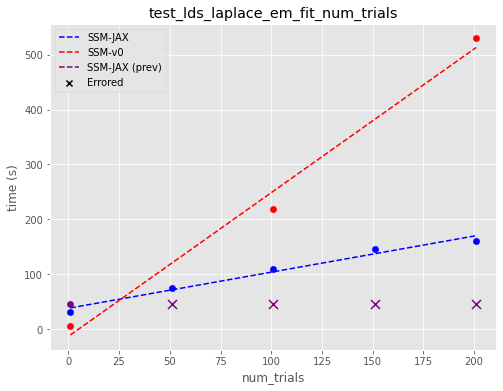

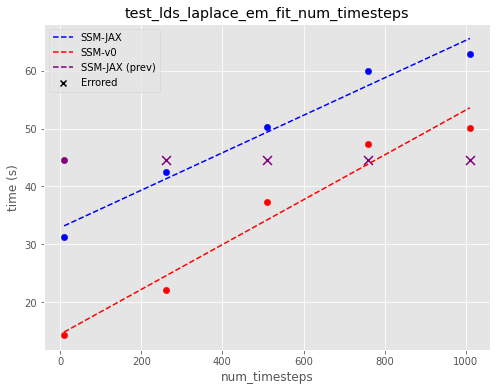

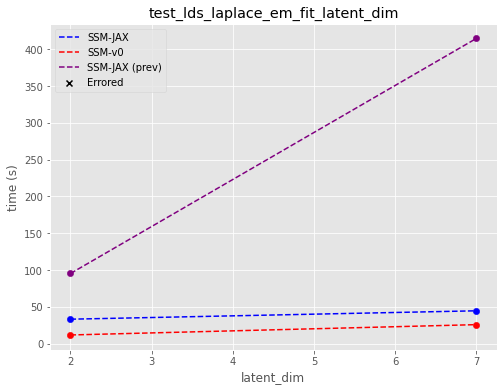

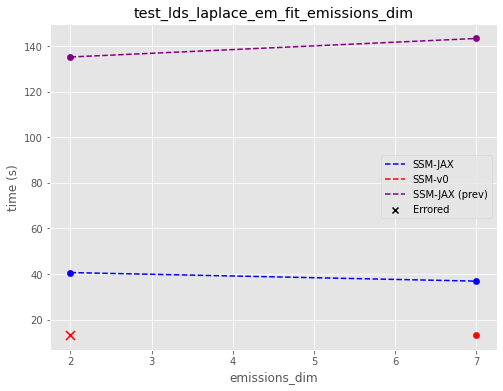

In [25]:
plot_benchmarks(include_prev=True)